# ** ONLY IN COLABS , Run and then Ignore this**

In [ ]:
#install import stuff, you need to login and give google permissions twice
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!pip install pandas==0.22

In [ ]:
#mount google drive
%cd
!mkdir -p drive
!google-drive-ocamlfuse drive

# the following takes pretty long ~ 15mins?

In [ ]:
#navigating your google drive and saving files inside.
%cd
%ls
%cd drive/
%mkdir github_st5220
%cd github_st5220
%rm -r Combating_obesity_food_classification
!git clone https://github.com/leexa90/Combating_obesity_food_classification.git
#download model parameters
%ls -lh */
%ls -lh
%cd Combating_obesity_food_classification
%ls -lh

# Due to limitations of github, the dataset here only contains 2500 test images, and 0 training images. 

## Section 1, Defining model

In [1]:
#sudo chmod 705 *
import numpy as np
import tensorflow as tf
#sess = tf.keras.backend.get_session()# as sess:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

data = pd.DataFrame(None,columns=['img_path','label'])
if False: #rsize dataset to 224*224
    from multiprocessing import Pool

    for category in sorted(os.listdir('./images')):
            def read(img_f,category=category):
                img = plt.imread('./images/'+category+'/'+img_f)
                plt.imsave('./images_299x299/'+category+'/'+img_f[:-4]+'.png',cv2.resize(img,(224,224)))
            p = Pool(6)
            #os.system('mkdir ./images_299x299/%s'%category)
            p.map(read , os.listdir('./images/'+category))
for category in sorted(os.listdir('./images'))[:]:
    file_names = list(map(lambda x : ('./images/'+category+'/'+x,category) ,
                          sorted(os.listdir('./images/'+category))))
    data = data.append(pd.DataFrame(file_names,columns=['img_path','label']))
    
data = data.reset_index(drop=True)
dictt = {}
unique_labels = sorted(pd.unique(data['label']))
counter =0 
for i in unique_labels:
    vec_label = np.array([0,]*len(unique_labels))
    vec_label[counter] = 1
    dictt[i] = vec_label
    counter += 1
data['vec_label'] = data['label'].map(dictt)
#data = data.iloc[::100].reset_index(drop=True)
data_test = data
data = data

filenames = data['img_path'].values
labels = np.stack(data['vec_label'],0)
filenames_test = data_test['img_path'].values
labels_test = np.stack(data_test['vec_label'],0)

def make_dataset(filenames, y_labels,batch,sess,oneshot=False):
        dataset = tf.data.Dataset.from_tensor_slices((filenames,y_labels))
        dataset = dataset.shuffle(len(filenames)) #buffer size as arguments
        def parse_function(filename, label):
            image_string = tf.read_file(filename)
            # Don't use tf.image.decode_image, or the output shape will be undefined
            image = tf.image.decode_png(image_string, channels=3)
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.resize_images(image,(299,299))
            # This will convert to float values in [0, 1]
            return image, label, filename
        dataset = dataset.map(parse_function, num_parallel_calls=6).repeat()
        dataset = dataset.batch(batch)
        dataset = dataset.prefetch(2)
        if oneshot:
                iterator = dataset.make_one_shot_iterator()
                img_input,input_label,z = iterator.get_next()
                return img_input,input_label,z
        iterator = dataset.make_initializable_iterator()#.make_one_shot_iterator()
        img_input,input_label,z = iterator.get_next()
        init_op= z
        init_op = iterator.initializer
        sess.run(init_op)
        return img_input,input_label,z,init_op

basemodel = tf.keras.applications.InceptionV3(input_shape=(299,299,3),include_top=False)
for layer in basemodel.layers:
    layer.trainable = True
final_layer =tf.keras.layers.GlobalAveragePooling2D()(basemodel.output)
final_layer2 = tf.keras.layers.Dropout(0.4)(final_layer)
logits = tf.keras.layers.Dense(len(unique_labels),'softmax',kernel_regularizer = tf.keras.regularizers.l2(0.0005))(final_layer)

model = tf.keras.models.Model(inputs=basemodel.input,outputs=logits)
#print (model.summary())
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,
                                                 verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('./mdl_wts.hdf5', save_best_only=True,
                                              monitor='val_loss', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                   patience=3, verbose=1, epsilon=1e-4, mode='min')
def sechdule(epoch):
    if epoch < 5 :
        return 0.01/2
    elif epoch < 10:
        return 0.002/2
    else:
        return 0.0004/2
lr_sechdule = tf.keras.callbacks.LearningRateScheduler(sechdule,verbose=1)
#model.compile(loss='categorical_crossentropy',
#              optimizer=tf.keras.optimizers.SGD(0.01,0.9),
#              metrics=['accuracy'])
tf.keras.backend.set_learning_phase(1) #freeze batch norm
sess = tf.keras.backend.get_session()# as sess:
img_input_T,input_label_T,z_T,init_op_T = make_dataset(filenames,labels,64,sess=sess)
img_input_V,input_label_V,z_V,init_op_V = make_dataset(filenames_test,labels_test,64,sess=sess)

aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")
def  data_gen (img_input_T,input_label_T):
    counter =0 
    while True:
        if counter %8 == 0:
            X_train,y_train = sess.run([img_input_T,input_label_T])
        for x,y in aug.flow(X_train,y_train,32):
            counter  += 1
            if counter %8==0:
                break
            yield (x,y)
        
def  data_gen (img_input_T,input_label_T,pred=False):
    while True:
        if pred == True:
                yield sess.run([img_input_T,])
        yield sess.run([img_input_T,input_label_T])
#print  (model.summary())

def categorical_focal_loss(gamma=2., alpha=.25):
    """
    https://github.com/umbertogriffo/focal-loss-keras/blob/master/losses.py
    Softmax version of focal loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy_T = -y_true * K.log(y_pred)
        cross_entropy_F = -(1-y_true) * K.log(1-y_pred) #added by xa

        # Calculate Focal Loss
        loss = alpha * (K.pow(1 - y_pred, gamma) * cross_entropy_T + K.pow(1 - (1-y_pred), gamma) * cross_entropy_F) #added by xa

        # Sum the losses in mini_batch
        return 4*K.sum(loss, axis=1)

    
    
    return categorical_focal_loss_fixed
import tensorflow.keras.backend as K
def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """
        alpha =2.
        gamma = 0.25
        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy_T = -y_true * K.log(y_pred)
        cross_entropy_F = -(1-y_true) * K.log(1-y_pred) #added by xa

        # Calculate Focal Loss
        loss = alpha * (K.pow(1 - y_pred, gamma) * cross_entropy_T + K.pow(1 - (1-y_pred), gamma) * cross_entropy_F) #added by xa

        # Sum the losses in mini_batch
        return 4*K.sum(loss, axis=1)



## 2. Loading model and validation

In [2]:
def  data_gen (img_input_T,input_label_T,pred=False):
    while True:
        if pred == True:
                yield sess.run([img_input_T,])
        yield sess.run([img_input_T,input_label_T])


In [3]:
model.load_weights('./Trained_foodnet.h5')

In [4]:
Val_results =pd.DataFrame(None,columns=['Predictions','Actual','filename'])
img_input_V,input_label_V,input_label_names = make_dataset(filenames_test,labels_test,101,sess=sess,oneshot=True)

In [5]:

for i in range(25):
    images,labels,names = sess.run([img_input_V,input_label_V,input_label_names])
    pred = model.predict(images)
    predTop = np.argmax(pred,1)
    ActualTop = np.argmax(labels,1)
    temp = pd.DataFrame(np.stack([predTop,ActualTop,names],1),columns=['Predictions','Actual','filename'])
    Val_results = Val_results.append(temp) #this is slow

In [6]:
dictt_int_name = {}
counter = 0
for i in pd.unique(data.label):
    dictt_int_name[counter] = i
    counter += 1
Val_results["Predictions"] = Val_results["Predictions"].map(dictt_int_name)
Val_results["Actual"] = Val_results["Actual"].map(dictt_int_name)

In [7]:
Val_results.head()

Predictions                 Actual  \
0                poutine                poutine   
1  lobster_roll_sandwich  lobster_roll_sandwich   
2              ice_cream          bread_pudding   
3               omelette               omelette   
4                ravioli          chicken_curry   

                                        filename  
0                b'./images/poutine/1408492.jpg'  
1  b'./images/lobster_roll_sandwich/1460366.jpg'  
2           b'./images/bread_pudding/272134.jpg'  
3               b'./images/omelette/3786113.jpg'  
4          b'./images/chicken_curry/2398119.jpg'

accuracy =  0.7956435643564357


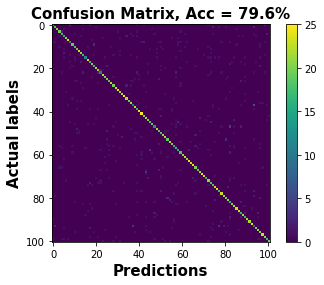

In [8]:
c=plt.imshow(pd.crosstab(Val_results['Actual'],Val_results['Predictions']));
plt.xlabel('Predictions',fontsize=15,fontweight='bold')
plt.ylabel('Actual labels',fontsize=15,fontweight='bold')
plt.title('Confusion Matrix, Acc = 79.6%',fontsize=15,fontweight='bold')
print ('accuracy = ',np.mean(Val_results['Predictions']==Val_results['Actual']))
plt.colorbar(c)
plt.show()

(array([ 1.,  2.,  2.,  1.,  1.,  0.,  6.,  9.,  9.,  7., 13., 14., 13.,
       12., 11.]), array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]), <a list of 15 Patch objects>)


Text(0, 0.5, 'probability density')

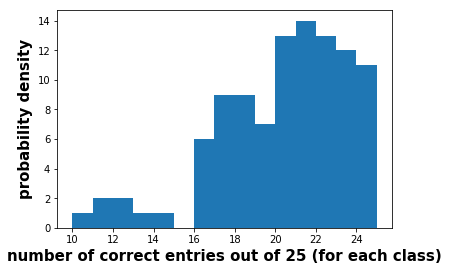

In [12]:
print (plt.hist(np.diag(pd.crosstab(Val_results['Actual'],Val_results['Predictions'])),range(10,26)))
plt.xlabel('number of correct entries out of 25 (for each class)',fontsize=15,fontweight='bold')
plt.ylabel('probability density',fontsize=15,fontweight='bold')

## Visualize all entries

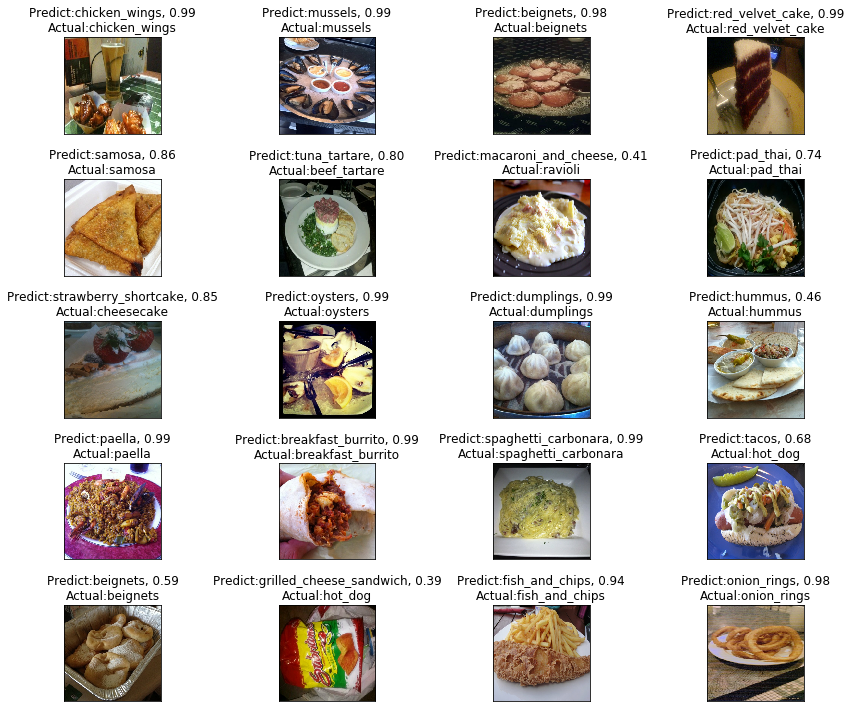

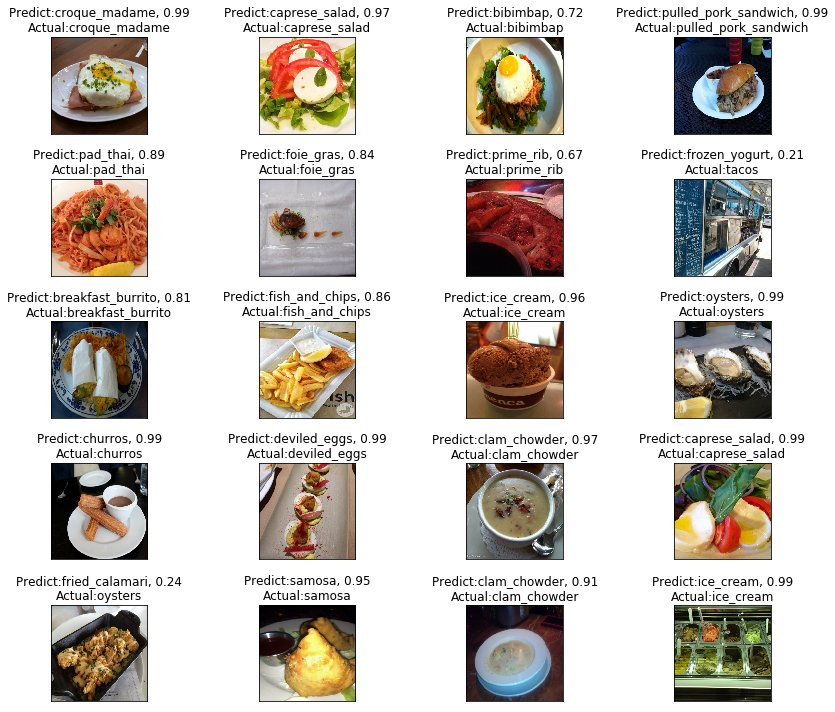

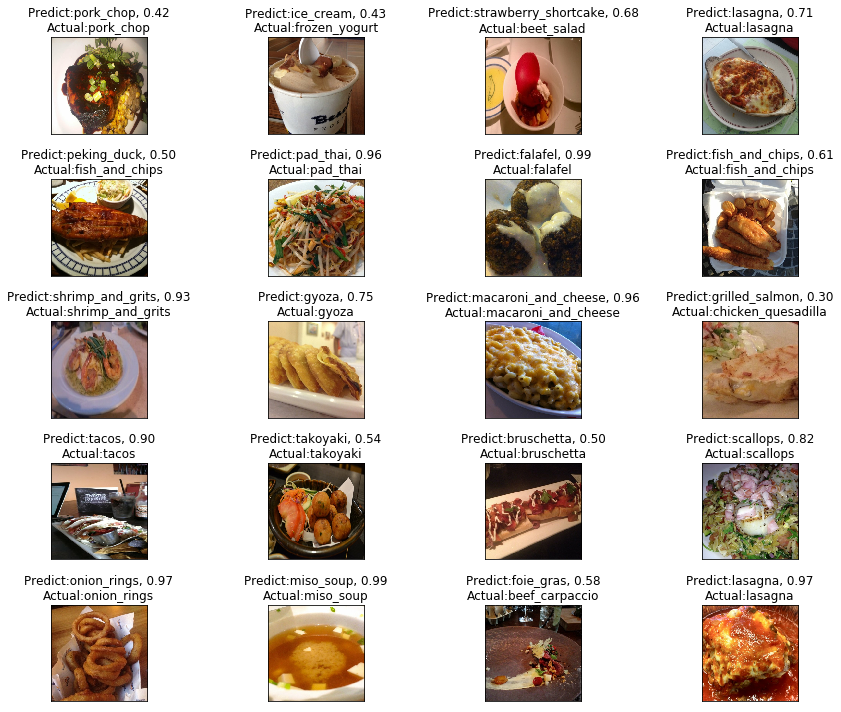

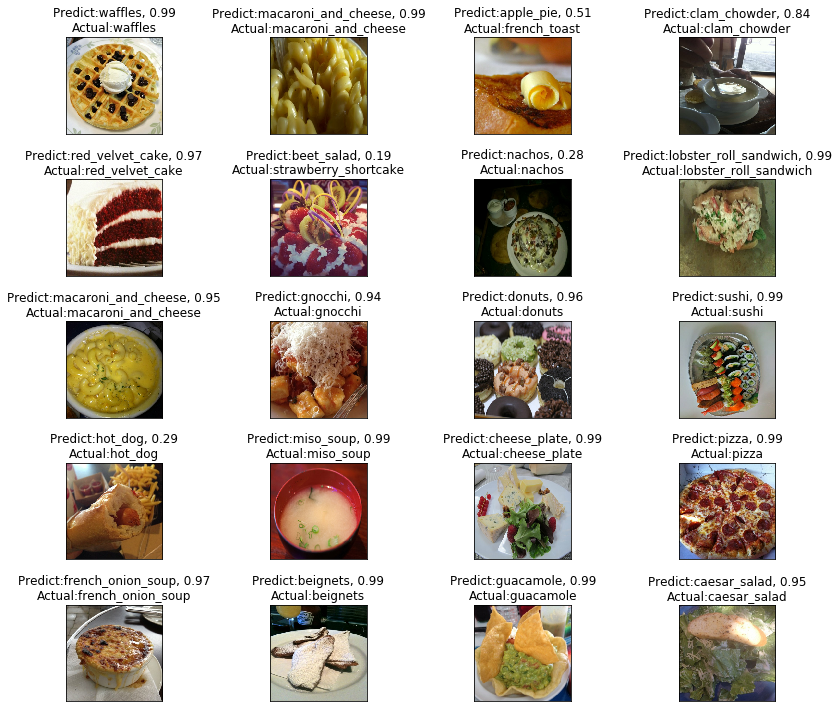

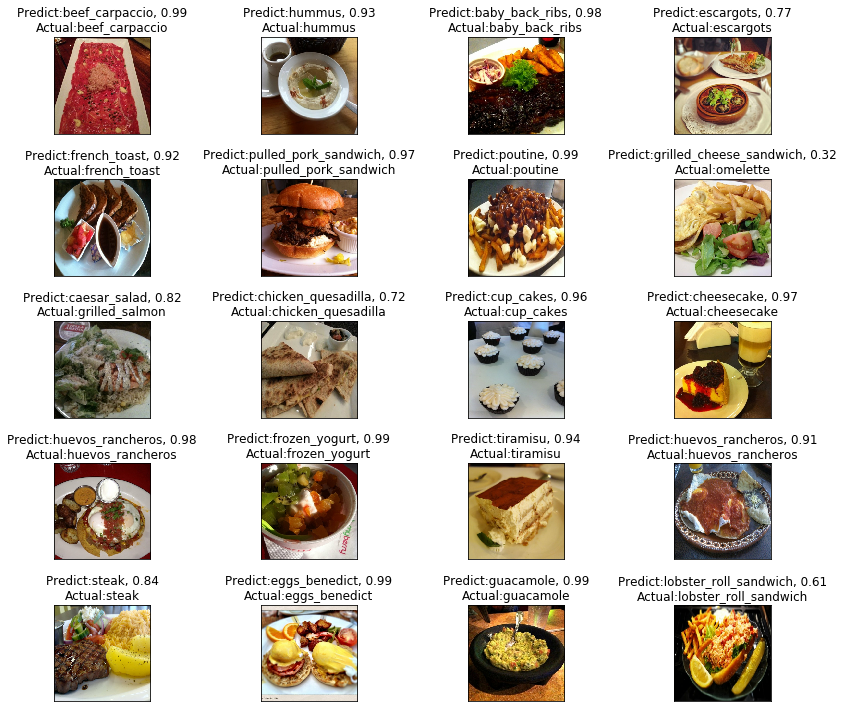

In [10]:
from matplotlib.gridspec import GridSpec
#img_input_V,input_label_V,input_label_names = make_dataset(filenames_test,labels_test,20,sess=sess,oneshot=True)
for i in range(5):
    fig=plt.figure(figsize=(12,10))
    #fig.suptitle('MSE between images =%s'%str(1), fontsize=10)
    gs=GridSpec(5,4) # 4 rows, 5 columns
    ax0a,ax0b=fig.add_subplot(gs[0,0]),fig.add_subplot(gs[0,1])
    ax1a,ax1b=fig.add_subplot(gs[0,3]),fig.add_subplot(gs[0,2]) 
    ax2a,ax2b=fig.add_subplot(gs[1,0]),fig.add_subplot(gs[1,1])
    ax3a,ax3b=fig.add_subplot(gs[1,3]),fig.add_subplot(gs[1,2]) 
    ax4a,ax4b=fig.add_subplot(gs[2,0]),fig.add_subplot(gs[2,1])
    ax5a,ax5b=fig.add_subplot(gs[2,3]),fig.add_subplot(gs[2,2])  
    ax6a,ax6b=fig.add_subplot(gs[3,0]),fig.add_subplot(gs[3,1])
    ax7a,ax7b=fig.add_subplot(gs[3,3]),fig.add_subplot(gs[3,2]) 
    ax8a,ax8b=fig.add_subplot(gs[4,0]),fig.add_subplot(gs[4,1]) 
    ax9a,ax9b=fig.add_subplot(gs[4,3]),fig.add_subplot(gs[4,2]) 
    ax = [ax0a,ax0b,ax1a,ax1b,ax2a,ax2b,ax3a,ax3b,ax4a,ax4b,ax5a,ax5b,ax6a,ax6b,ax7a,ax7b,ax8a,ax8b,ax9a,ax9b]
    images,labels,names = sess.run([img_input_V,input_label_V,input_label_names])
    pred = model.predict(images)
    predTop = np.argmax(pred,1)
    ActualTop = np.argmax(labels,1)
    for j in range(20):
        ax[j].imshow(images[j])
        predName = dictt_int_name[predTop[j]]
        ActualName = dictt_int_name[ActualTop[j]]
        percentage =  str(pred[j][predTop[j]])[:4]
        ax[j].set_title('Predict:'+predName+', '+percentage+'\n'
                       'Actual:'+ActualName )
        ax[j].set_xticks([])
        ax[j].set_yticks([])
    plt.tight_layout()
    plt.show()
    plt.close()
        

## Visualize wrong predictions

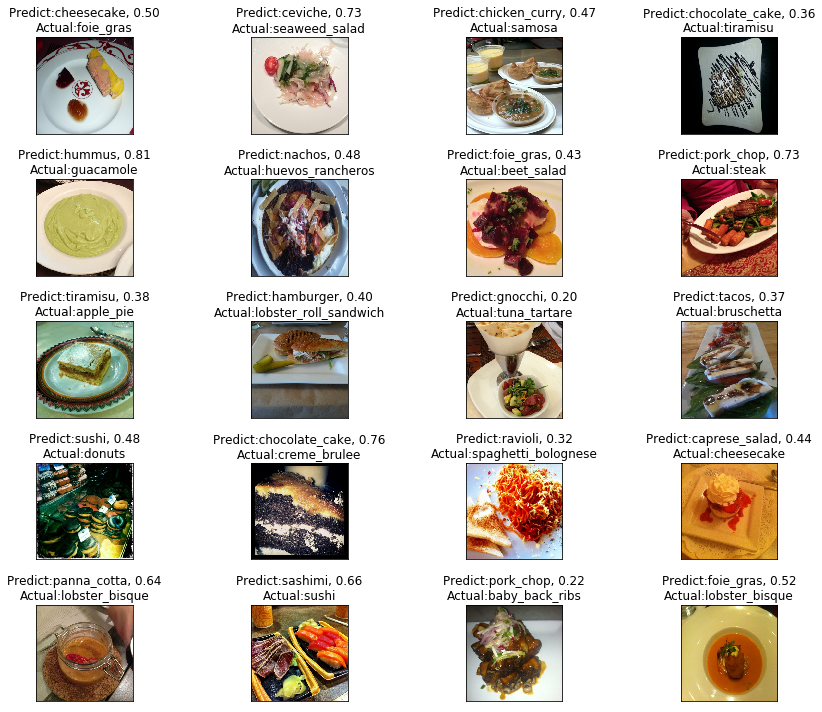

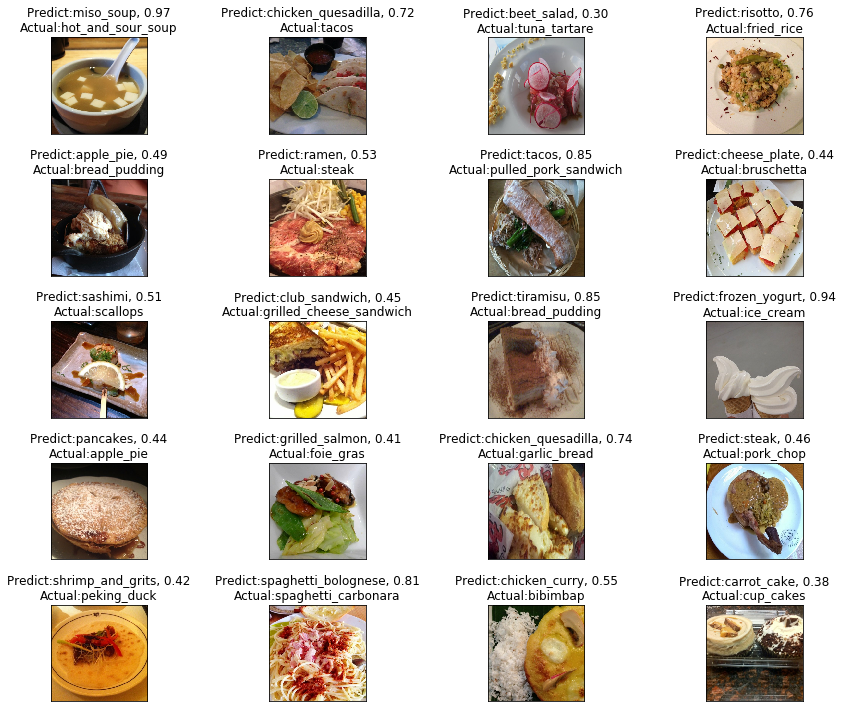

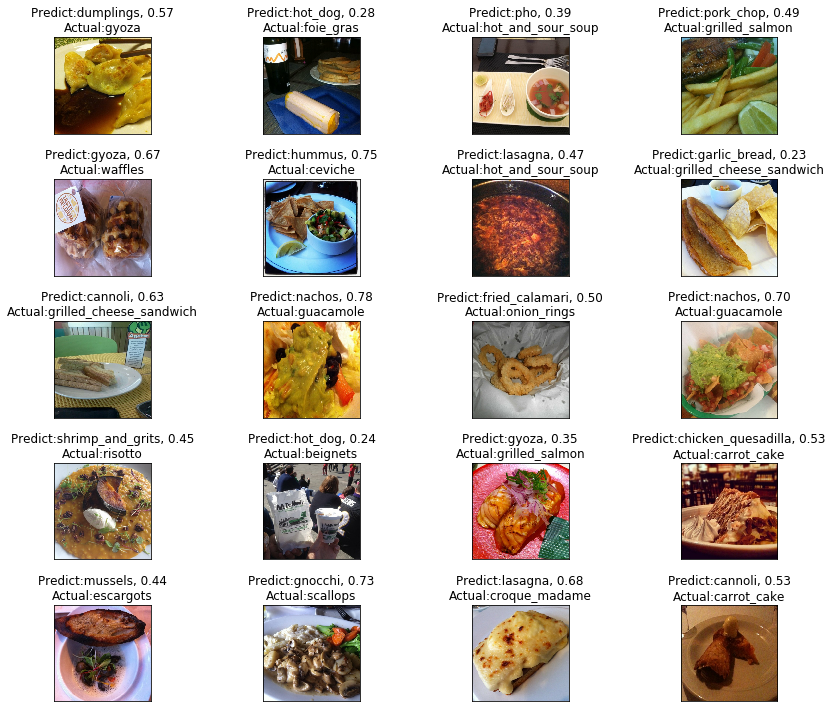

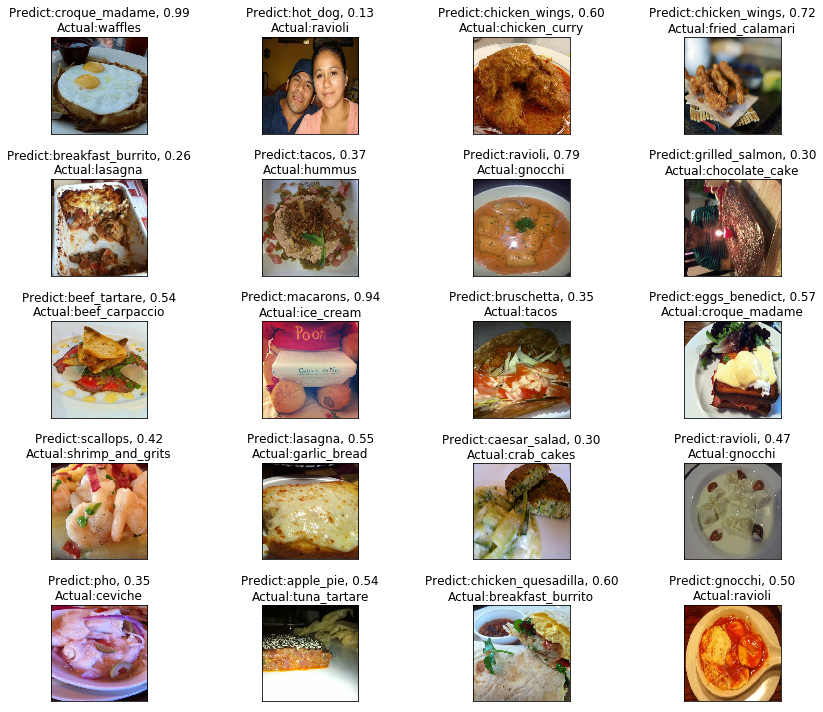

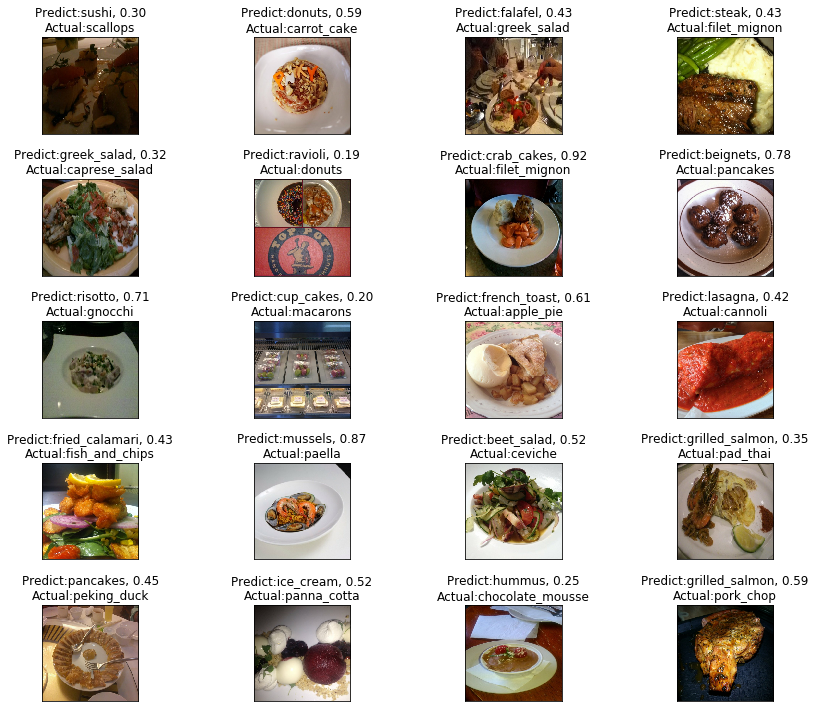

In [11]:
from matplotlib.gridspec import GridSpec
#img_input_V,input_label_V,input_label_names = make_dataset(filenames_test,labels_test,50,sess=sess,oneshot=True)
for i in range(5):
    fig=plt.figure(figsize=(12,10))
    #fig.suptitle('MSE between images =%s'%str(1), fontsize=10)
    gs=GridSpec(5,4) # 4 rows, 5 columns
    ax0a,ax0b=fig.add_subplot(gs[0,0]),fig.add_subplot(gs[0,1])
    ax1a,ax1b=fig.add_subplot(gs[0,3]),fig.add_subplot(gs[0,2]) 
    ax2a,ax2b=fig.add_subplot(gs[1,0]),fig.add_subplot(gs[1,1])
    ax3a,ax3b=fig.add_subplot(gs[1,3]),fig.add_subplot(gs[1,2]) 
    ax4a,ax4b=fig.add_subplot(gs[2,0]),fig.add_subplot(gs[2,1])
    ax5a,ax5b=fig.add_subplot(gs[2,3]),fig.add_subplot(gs[2,2])  
    ax6a,ax6b=fig.add_subplot(gs[3,0]),fig.add_subplot(gs[3,1])
    ax7a,ax7b=fig.add_subplot(gs[3,3]),fig.add_subplot(gs[3,2]) 
    ax8a,ax8b=fig.add_subplot(gs[4,0]),fig.add_subplot(gs[4,1]) 
    ax9a,ax9b=fig.add_subplot(gs[4,3]),fig.add_subplot(gs[4,2]) 
    ax = [ax0a,ax0b,ax1a,ax1b,ax2a,ax2b,ax3a,ax3b,ax4a,ax4b,ax5a,ax5b,ax6a,ax6b,ax7a,ax7b,ax8a,ax8b,ax9a,ax9b]
    counter = 0
    for jj in range(2):
        if jj%1==0:
            images,labels,names = sess.run([img_input_V,input_label_V,input_label_names])
            pred = model.predict(images)
            predTop = np.argmax(pred,1)
            ActualTop = np.argmax(labels,1)

            for j in np.concatenate(np.argwhere(predTop!=ActualTop)): 
                if counter == 20:
                    break
                predName = dictt_int_name[predTop[j]]
                ActualName = dictt_int_name[ActualTop[j]]
                ax[counter].imshow(images[j])
                percentage =  str(pred[j][predTop[j]])[:4]
                ax[counter].set_title('Predict:'+predName+', '+percentage+'\n'
                               'Actual:'+ActualName )
                ax[counter].set_xticks([])
                ax[counter].set_yticks([])
                counter +=1 
    plt.tight_layout()
    plt.show()
    plt.close()
        

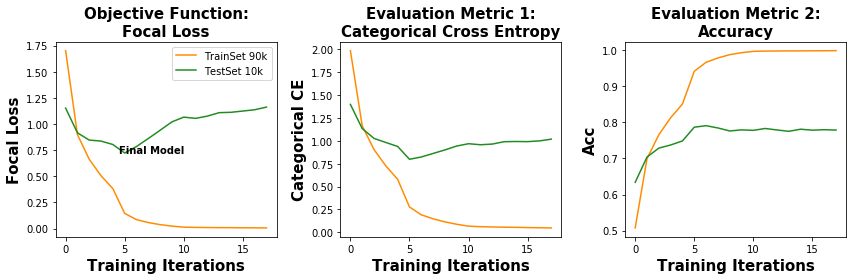

In [59]:
# Training log
fig,ax = plt.subplots(1,3,figsize=(12,4))
data_focal = pd.read_csv('Training_log_focalLoss.log')
data_categoricalCE = pd.read_csv('./Training_log_categoricalCrossEntropyLoss.log')
ax[0].plot(data_focal.epoch,data_focal.categorical_focal_loss_fixed,color='darkorange',label='TrainSet 90k')
ax[0].plot(data_focal.epoch,data_focal.val_categorical_focal_loss_fixed,color='forestgreen',label='TestSet 10k')
ax[1].plot(data_focal.epoch,data_focal.categorical_crossentropy,color='darkorange',label='TrainSet 90k')
ax[1].plot(data_focal.epoch,data_focal.val_categorical_crossentropy,color='forestgreen',label='TestSet 10k')
ax[2].plot(data_focal.epoch,data_focal.acc,color='darkorange',label='TrainSet 90k')
ax[2].plot(data_focal.epoch,data_focal.val_acc,color='forestgreen',label='TestSet 10k')
ax[0].text(data_focal.epoch.values[5]-.5,data_focal.val_categorical_focal_loss_fixed.values[5],
          'Final Model',fontweight='bold',fontsize=10)
ylabel = ['Focal Loss','Categorical CE','Acc']
title = ['Objective Function:\nFocal Loss','Evaluation Metric 1:\nCategorical Cross Entropy',
         'Evaluation Metric 2:\nAccuracy']
for i in range(3):
    ax[i].set_xticklabels(map(int,ax[0].get_xticks()))
    ax[i].set_xlabel('Training Iterations',fontweight='bold',fontsize=15)
    ax[i].set_ylabel(ylabel[i],fontweight='bold',fontsize=15)
    ax[i].set_title(title[i],fontweight='bold',fontsize=15)
ax[0].legend()
plt.tight_layout()
plt.savefig('./Training_log_focalLoss.png',dpi=300)
plt.show()

plt.close()

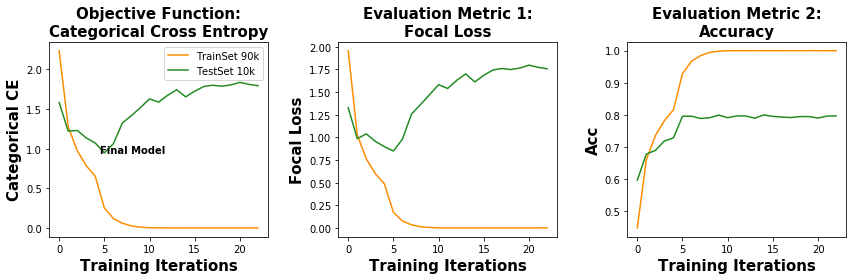

In [58]:
# Training log
fig,ax = plt.subplots(1,3,figsize=(12,4))
data_categoricalCE = pd.read_csv('./Training_log_categoricalCrossEntropyLoss.log')
# scaled this by four in latter runs, scaled for easy comparison
data_categoricalCE['categorical_focal_loss_fixed'] = data_categoricalCE['categorical_focal_loss_fixed']*4
data_categoricalCE['val_categorical_focal_loss_fixed'] = data_categoricalCE['val_categorical_focal_loss_fixed']*4
ax[1].plot(data_categoricalCE.epoch,data_categoricalCE.categorical_focal_loss_fixed,color='darkorange',label='TrainSet 90k')
ax[1].plot(data_categoricalCE.epoch,data_categoricalCE.val_categorical_focal_loss_fixed,color='forestgreen',label='TestSet 10k')
ax[0].plot(data_categoricalCE.epoch,data_categoricalCE.categorical_crossentropy,color='darkorange',label='TrainSet 90k')
ax[0].plot(data_categoricalCE.epoch,data_categoricalCE.val_categorical_crossentropy,color='forestgreen',label='TestSet 10k')
ax[2].plot(data_categoricalCE.epoch,data_categoricalCE.acc,color='darkorange',label='TrainSet 90k')
ax[2].plot(data_categoricalCE.epoch,data_categoricalCE.val_acc,color='forestgreen',label='TestSet 10k')
ax[0].text(data_categoricalCE.epoch.values[5]-.5,data_categoricalCE.val_categorical_crossentropy.values[5],
          'Final Model',fontweight='bold',fontsize=10)
ylabel = ['Categorical CE','Focal Loss','Acc']
title = ['Objective Function:\nCategorical Cross Entropy','Evaluation Metric 1:\nFocal Loss',
         'Evaluation Metric 2:\nAccuracy']
for i in range(3):
    ax[i].set_xticklabels(map(int,ax[0].get_xticks()))
    ax[i].set_xlabel('Training Iterations',fontweight='bold',fontsize=15)
    ax[i].set_ylabel(ylabel[i],fontweight='bold',fontsize=15)
    ax[i].set_title(title[i],fontweight='bold',fontsize=15)
ax[0].legend()
plt.tight_layout()
plt.savefig('./Training_log_CategoricalCE.png',dpi=300)
plt.show()

plt.close()

In [17]:
data_focal.head()

epoch       acc  categorical_crossentropy  categorical_focal_loss_fixed  \
0      0  0.507350                  1.987031                      1.701307   
1      1  0.699385                  1.164576                      0.898459   
2      2  0.765799                  0.905058                      0.661982   
3      3  0.812957                  0.726272                      0.504555   
4      4  0.851100                  0.579661                      0.380841   

       loss   val_acc  val_categorical_crossentropy  \
0  1.797180  0.633957                      1.399211   
1  0.992882  0.704021                      1.134893   
2  0.754758  0.728802                      1.027212   
3  0.595714  0.737460                      0.982661   
4  0.470446  0.748706                      0.939221   

   val_categorical_focal_loss_fixed  val_loss  
0                          1.151715  1.246931  
1                          0.915171  1.008754  
2                          0.846008  0.937953  
3                          0.836289  0.926659  
4                          0.803575  0.892405

# Model Training below

In [ ]:
def sechdule(epoch):
    if epoch < 5 :
        return 0.01/10
    elif epoch < 10:
        return 0.002/10
    else:
        return 0.0004/10
model.compile(loss=categorical_focal_loss(alpha=.25, gamma=2),
              optimizer=tf.keras.optimizers.SGD(0.01,0.9),
              metrics=['accuracy','categorical_crossentropy',
                      categorical_focal_loss(alpha=.25, gamma=2)])
lr_sechdule = tf.keras.callbacks.LearningRateScheduler(sechdule,verbose=1)
if True:
    #model.load_weights('./model4.01-1.68.hdf5')
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model_focalXA_4.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
    csv_logger = tf.keras.callbacks.CSVLogger('model_focalXA_4.log')
    model.fit_generator(data_gen (img_input_T,input_label_T),92000//64,50,
                        verbose=1,callbacks=[checkpointer,csv_logger, lr_sechdule],
                        validation_data = data_gen(img_input_V,input_label_V),
                        validation_steps = 10100//64)
model.save_weights('initial.h5')

In [ ]:
#Model training log

'''
Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/50
1436/1437 [============================>.] - ETA: 2s - loss: 1.7974 - acc: 0.5073 - categorical_crossentropy: 1.9873 - categorical_focal_loss_fixed: 1.7015
Epoch 00001: val_loss improved from inf to 1.24693, saving model to model_focalXA_4.01-1.25.hdf5
1437/1437 [==============================] - 3242s 2s/step - loss: 1.7972 - acc: 0.5074 - categorical_crossentropy: 1.9870 - categorical_focal_loss_fixed: 1.7013 - val_loss: 1.2469 - val_acc: 0.6340 - val_categorical_crossentropy: 1.3992 - val_categorical_focal_loss_fixed: 1.1517

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/50
1436/1437 [============================>.] - ETA: 2s - loss: 0.9932 - acc: 0.6993 - categorical_crossentropy: 1.1648 - categorical_focal_loss_fixed: 0.8987
Epoch 00002: val_loss improved from 1.24693 to 1.00875, saving model to model_focalXA_4.02-1.01.hdf5
1437/1437 [==============================] - 3156s 2s/step - loss: 0.9929 - acc: 0.6994 - categorical_crossentropy: 1.1646 - categorical_focal_loss_fixed: 0.8985 - val_loss: 1.0088 - val_acc: 0.7040 - val_categorical_crossentropy: 1.1349 - val_categorical_focal_loss_fixed: 0.9152

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/50
1436/1437 [============================>.] - ETA: 2s - loss: 0.7548 - acc: 0.7658 - categorical_crossentropy: 0.9052 - categorical_focal_loss_fixed: 0.6621
Epoch 00003: val_loss improved from 1.00875 to 0.93795, saving model to model_focalXA_4.03-0.94.hdf5
1437/1437 [==============================] - 3156s 2s/step - loss: 0.7548 - acc: 0.7658 - categorical_crossentropy: 0.9051 - categorical_focal_loss_fixed: 0.6620 - val_loss: 0.9380 - val_acc: 0.7288 - val_categorical_crossentropy: 1.0272 - val_categorical_focal_loss_fixed: 0.8460

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/50
1436/1437 [============================>.] - ETA: 2s - loss: 0.5958 - acc: 0.8129 - categorical_crossentropy: 0.7264 - categorical_focal_loss_fixed: 0.5046
Epoch 00004: val_loss improved from 0.93795 to 0.92666, saving model to model_focalXA_4.04-0.93.hdf5
1437/1437 [==============================] - 3161s 2s/step - loss: 0.5957 - acc: 0.8130 - categorical_crossentropy: 0.7263 - categorical_focal_loss_fixed: 0.5046 - val_loss: 0.9267 - val_acc: 0.7375 - val_categorical_crossentropy: 0.9827 - val_categorical_focal_loss_fixed: 0.8363

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
Epoch 5/50
1436/1437 [============================>.] - ETA: 2s - loss: 0.4704 - acc: 0.8511 - categorical_crossentropy: 0.5796 - categorical_focal_loss_fixed: 0.3808
Epoch 00005: val_loss improved from 0.92666 to 0.89241, saving model to model_focalXA_4.05-0.89.hdf5
1437/1437 [==============================] - 3144s 2s/step - loss: 0.4704 - acc: 0.8511 - categorical_crossentropy: 0.5797 - categorical_focal_loss_fixed: 0.3808 - val_loss: 0.8924 - val_acc: 0.7487 - val_categorical_crossentropy: 0.9392 - val_categorical_focal_loss_fixed: 0.8036

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 6/50
1436/1437 [============================>.] - ETA: 2s - loss: 0.2330 - acc: 0.9419 - categorical_crossentropy: 0.2773 - categorical_focal_loss_fixed: 0.1443
Epoch 00006: val_loss improved from 0.89241 to 0.81054, saving model to model_focalXA_4.06-0.81.hdf5
1437/1437 [==============================] - 3145s 2s/step - loss: 0.2331 - acc: 0.9419 - categorical_crossentropy: 0.2775 - categorical_focal_loss_fixed: 0.1445 - val_loss: 0.8105 - val_acc: 0.7868 - val_categorical_crossentropy: 0.7989 - val_categorical_focal_loss_fixed: 0.7221

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 7/50
1436/1437 [============================>.] - ETA: 2s - loss: 0.1732 - acc: 0.9669 - categorical_crossentropy: 0.1915 - categorical_focal_loss_fixed: 0.0850
Epoch 00007: val_loss did not improve from 0.81054
1437/1437 [==============================] - 3144s 2s/step - loss: 0.1731 - acc: 0.9669 - categorical_crossentropy: 0.1915 - categorical_focal_loss_fixed: 0.0849 - val_loss: 0.8725 - val_acc: 0.7910 - val_categorical_crossentropy: 0.8241 - val_categorical_focal_loss_fixed: 0.7845

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 8/50
1436/1437 [============================>.] - ETA: 2s - loss: 0.1447 - acc: 0.9789 - categorical_crossentropy: 0.1480 - categorical_focal_loss_fixed: 0.0569
Epoch 00008: val_loss did not improve from 0.81054
1437/1437 [==============================] - 3153s 2s/step - loss: 0.1446 - acc: 0.9789 - categorical_crossentropy: 0.1480 - categorical_focal_loss_fixed: 0.0568 - val_loss: 0.9486 - val_acc: 0.7847 - val_categorical_crossentropy: 0.8628 - val_categorical_focal_loss_fixed: 0.8611

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 9/50
1436/1437 [============================>.] - ETA: 2s - loss: 0.1245 - acc: 0.9880 - categorical_crossentropy: 0.1142 - categorical_focal_loss_fixed: 0.0372
Epoch 00009: val_loss did not improve from 0.81054
1437/1437 [==============================] - 3150s 2s/step - loss: 0.1245 - acc: 0.9880 - categorical_crossentropy: 0.1142 - categorical_focal_loss_fixed: 0.0371 - val_loss: 1.0274 - val_acc: 0.7764 - val_categorical_crossentropy: 0.9013 - val_categorical_focal_loss_fixed: 0.9402

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 10/50
1436/1437 [============================>.] - ETA: 2s - loss: 0.1098 - acc: 0.9935 - categorical_crossentropy: 0.0881 - categorical_focal_loss_fixed: 0.0229
Epoch 00010: val_loss did not improve from 0.81054
1437/1437 [==============================] - 3153s 2s/step - loss: 0.1098 - acc: 0.9935 - categorical_crossentropy: 0.0881 - categorical_focal_loss_fixed: 0.0229 - val_loss: 1.1070 - val_acc: 0.7794 - val_categorical_crossentropy: 0.9441 - val_categorical_focal_loss_fixed: 1.0203

Epoch 00011: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 11/50
1436/1437 [============================>.] - ETA: 2s - loss: 0.0997 - acc: 0.9972 - categorical_crossentropy: 0.0672 - categorical_focal_loss_fixed: 0.0130
Epoch 00011: val_loss did not improve from 0.81054
1437/1437 [==============================] - 3156s 2s/step - loss: 0.0997 - acc: 0.9972 - categorical_crossentropy: 0.0672 - categorical_focal_loss_fixed: 0.0130 - val_loss: 1.1522 - val_acc: 0.7781 - val_categorical_crossentropy: 0.9692 - val_categorical_focal_loss_fixed: 1.0655

Epoch 00012: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 12/50
1436/1437 [============================>.] - ETA: 2s - loss: 0.0972 - acc: 0.9980 - categorical_crossentropy: 0.0618 - categorical_focal_loss_fixed: 0.0106
Epoch 00012: val_loss did not improve from 0.81054
1437/1437 [==============================] - 3162s 2s/step - loss: 0.0972 - acc: 0.9980 - categorical_crossentropy: 0.0618 - categorical_focal_loss_fixed: 0.0106 - val_loss: 1.1402 - val_acc: 0.7832 - val_categorical_crossentropy: 0.9580 - val_categorical_focal_loss_fixed: 1.0537

Epoch 00013: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 13/50
1436/1437 [============================>.] - ETA: 2s - loss: 0.0959 - acc: 0.9982 - categorical_crossentropy: 0.0586 - categorical_focal_loss_fixed: 0.0094
Epoch 00013: val_loss did not improve from 0.81054
1437/1437 [==============================] - 3160s 2s/step - loss: 0.0959 - acc: 0.9982 - categorical_crossentropy: 0.0586 - categorical_focal_loss_fixed: 0.0094 - val_loss: 1.1619 - val_acc: 0.7792 - val_categorical_crossentropy: 0.9652 - val_categorical_focal_loss_fixed: 1.0754

Epoch 00014: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 14/50
1436/1437 [============================>.] - ETA: 2s - loss: 0.0948 - acc: 0.9985 - categorical_crossentropy: 0.0560 - categorical_focal_loss_fixed: 0.0084
Epoch 00014: val_loss did not improve from 0.81054
1437/1437 [==============================] - 3163s 2s/step - loss: 0.0948 - acc: 0.9985 - categorical_crossentropy: 0.0560 - categorical_focal_loss_fixed: 0.0084 - val_loss: 1.1946 - val_acc: 0.7754 - val_categorical_crossentropy: 0.9912 - val_categorical_focal_loss_fixed: 1.1083

Epoch 00015: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 15/50
1436/1437 [============================>.] - ETA: 2s - loss: 0.0944 - acc: 0.9986 - categorical_crossentropy: 0.0546 - categorical_focal_loss_fixed: 0.0080
Epoch 00015: val_loss did not improve from 0.81054
1437/1437 [==============================] - 3157s 2s/step - loss: 0.0944 - acc: 0.9985 - categorical_crossentropy: 0.0546 - categorical_focal_loss_fixed: 0.0080 - val_loss: 1.1979 - val_acc: 0.7812 - val_categorical_crossentropy: 0.9935 - val_categorical_focal_loss_fixed: 1.1116

Epoch 00016: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 16/50
1436/1437 [============================>.] - ETA: 2s - loss: 0.0933 - acc: 0.9987 - categorical_crossentropy: 0.0518 - categorical_focal_loss_fixed: 0.0071
Epoch 00016: val_loss did not improve from 0.81054
1437/1437 [==============================] - 3155s 2s/step - loss: 0.0933 - acc: 0.9987 - categorical_crossentropy: 0.0518 - categorical_focal_loss_fixed: 0.0070 - val_loss: 1.2100 - val_acc: 0.7786 - val_categorical_crossentropy: 0.9921 - val_categorical_focal_loss_fixed: 1.1238

Epoch 00017: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 17/50
1436/1437 [============================>.] - ETA: 2s - loss: 0.0927 - acc: 0.9989 - categorical_crossentropy: 0.0502 - categorical_focal_loss_fixed: 0.0066
Epoch 00017: val_loss did not improve from 0.81054
1437/1437 [==============================] - 3143s 2s/step - loss: 0.0927 - acc: 0.9989 - categorical_crossentropy: 0.0502 - categorical_focal_loss_fixed: 0.0066 - val_loss: 1.2221 - val_acc: 0.7799 - val_categorical_crossentropy: 1.0000 - val_categorical_focal_loss_fixed: 1.1360

Epoch 00018: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 18/50
1436/1437 [============================>.] - ETA: 2s - loss: 0.0916 - acc: 0.9992 - categorical_crossentropy: 0.0480 - categorical_focal_loss_fixed: 0.0055
Epoch 00018: val_loss did not improve from 0.81054
1437/1437 [==============================] - 3140s 2s/step - loss: 0.0916 - acc: 0.9992 - categorical_crossentropy: 0.0480 - categorical_focal_loss_fixed: 0.0055 - val_loss: 1.2474 - val_acc: 0.7789 - val_categorical_crossentropy: 1.0191 - val_categorical_focal_loss_fixed: 1.1614

Epoch 00019: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 19/50
 555/1437 [==========>...................] - ETA: 31:10 - loss: 0.0919 - acc: 0.9991 - categorical_crossentropy: 0.0476 - categorical_focal_loss_fixed: 0.0059''''''